## 1. Data processing

Before we can begin analysing the data, we need to get it and "clean" it so that we can run computations on it.

In [1]:
%matplotlib inline

import ast 
import csv
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# pretty plotting
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 5]

In [3]:
# First lets parse the data
reader = csv.reader(open("movie_recommendations.csv", "rb"), delimiter=",")
data = list(reader)
print data

[['Movie Title ', 'Genre of Movie ', 'My Rating on IMDb', 'IMDb Rating ', 'Metacritic Score ', 'Rotten Tomato Freshness'], ['', '', '', '', '', ''], ['1) Confidence (2003)', 'Crime/Thriller/Heist', '7/10', '6.3/10', '59', '69%'], ['2) Monty Python and the Holy Grail (1975)', 'Comedy', '8/10', '8.3/10', '93', '97%'], ['3) God Bless America (2011) ', 'Comedy', '8/10', '7.2/10', '56', '67%'], ['4) Pitch Perfect (2012)', 'Comedy/Music', '8/10', '7.2/10', '66', '80%'], ['5) Seven Psycopaths (2012)', 'Comedy/Crime', '9/10', '7.2/10', '66', '82%'], ['6) How To Rob a Bank (2007)', 'Comedy/Crime/Heist', '7/10', '6.1/10', '27', '17%'], ['7) Con Air (1997)', 'Action', '8/10', '6.8/10', '52', '55%'], ['8) Hansel and Gretel: Witch Hunters (2013)', 'Action/Fantasy/Horror', '7/10', '6.1/10', '21', '14%'], ['9) Dredd (2012)', 'Action/Sci-Fi', '8/10', '7.1/10', '59', '78%'], ['10) Invincible (2006)', 'Biopic/Drama/Sport', '7/10', '7.1/10', '63', '72%'], ['11) Flight (2012)', 'Drama ', '7/10', '7.3/10',

In [4]:
# The first row has header info and the second row is empty, so we can ignore them.
# Note: the data is stored as strings, so we need to process it some more
text_data = np.array(data[2:])

movie_titles = [unicode(title, 'utf-8') for title in text_data[:,0]]
raw_movie_genres = text_data[:,1]
raw_omkar_ratings = text_data[:,2]
raw_imdb_ratings = text_data[:,3]
# -SOON->
# raw_meta_critic_ratings = result[:,4]
# raw_rotten_tomato_ratings = result[:,5]

In [5]:
# Now lets normalize these ratings so they are between 0 and 1
from __future__ import division # so that python will evaluate 3/10 as a floating pt operation instead of an integer op

def string_to_numpy(string_arr):
    tmp_list = []
    for string_val in string_arr:
        if string_val is 'N/A':
            tmp_list.append(0)
        else:
            tmp_list.append(eval(string_val))
    return np.asarray(tmp_list).astype("float")

omkar_ratings = string_to_numpy(raw_omkar_ratings)
imdb_ratings = string_to_numpy(raw_imdb_ratings)

## 2. Analysis

Lets look at the raw data first:

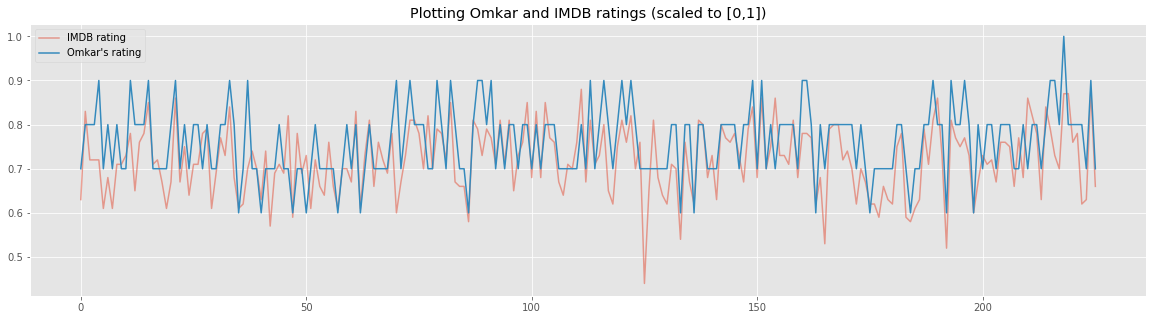

In [6]:
assert len(imdb_ratings) == len(movie_titles)
# plt.xticks(range(len(imdb_ratings)), movie_titles, rotation=90) # <- too messy :(
# Remember, we scalled all scores to [0,1]!
plt.plot(imdb_ratings, alpha=0.5, label="IMDB rating")
plt.plot(omkar_ratings, alpha=1.0, label="Omkar's rating")
plt.legend()
plt.title('Plotting Omkar and IMDB ratings (scaled to [0,1])')
plt.show()

_Phew!_ That's a pretty dense chart and on its own we can quickly surmise how closely related Omkar's ratings are w.r.t IMDB. For a single number statistic, let's look at [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) between Omakar and IMDB:

In [7]:
print "Overall IMDB corellation: ",np.corrcoef(omkar_ratings, imdb_ratings)[0,1]

Overall IMDB corellation:  0.6404962063207162


On its own, the correlation doesn't tell us much. Let's look at where the largest difference between Omkar and IMDB come up:

In [26]:
def analyze_diff(diff_omkar_imdb, title):
    print 'Max difference: ', diff_omkar_imdb.max()
    print 'Min difference: ', diff_omkar_imdb.min()
    print 'Mean: ', diff_omkar_imdb.mean()
    print 'Std dev: ', diff_omkar_imdb.std()

    below_1_sigma = np.array(diff_omkar_imdb < (diff_omkar_imdb.mean() - diff_omkar_imdb.std()))
    above_1_sigma = np.array(diff_omkar_imdb > (diff_omkar_imdb.mean() + diff_omkar_imdb.std()))
    # everything that's not 1 sigma above/below the mean
    rest = np.logical_not(below_1_sigma) & np.logical_not(above_1_sigma)

    _x_axis = np.arange(len(imdb_ratings))

    plt.bar(_x_axis[above_1_sigma], diff_omkar_imdb[above_1_sigma], label='Above 1 $\sigma$')
    plt.bar(_x_axis[below_1_sigma], diff_omkar_imdb[below_1_sigma], label='Below 1 $\sigma$')
    plt.bar(_x_axis[rest], diff_omkar_imdb[rest], alpha=0.5, label='Within 2 $\sigma$')
    plt.legend()
    plt.title(title)
    
    high_positive_diff = []
    high_negative_diff = []

    for idx in range(len(movie_titles)):
        if above_1_sigma[idx]:
            high_positive_diff.append((movie_titles[idx], diff_omkar_imdb[idx]))
        if below_1_sigma[idx]:
            high_negative_diff.append((movie_titles[idx], diff_omkar_imdb[idx]))


    # Note: diff = Omkar - IMDB, so a positive score indicates Omkar rated a movie higher and vice versa
    print 'Movies that are above 1 sigma from the mean difference b/w Omkar and IMDB: (total: {})'.format(len(high_positive_diff))
    for movie_title, diff in high_positive_diff:
        print '\tMovie: {}, diff: {}'.format(movie_title.encode('utf-8'), diff)

    print 'Movies that are below 1 sigma from the mean difference b/w Omkar and IMDB: (total: {})'.format(len(high_negative_diff))
    for movie_title, diff in high_negative_diff:
        print '\tMovie: {}, diff: {}'.format(movie_title.encode('utf-8'), diff)
    
    return

Max difference:  0.30000000000000004
Min difference:  -0.16000000000000003
Mean:  0.041283185840707975
Std dev:  0.0667225093735769
Movies that are above 1 sigma from the mean difference b/w Omkar and IMDB: (total: 32)
	Movie: 5) Seven Psycopaths (2012), diff: 0.18
	Movie: 7) Con Air (1997), diff: 0.12
	Movie: 12) Silver Linings Playbook (2012), diff: 0.12
	Movie: 13) Mere Dad Ki Maruti (2013), diff: 0.15
	Movie: 21) Killer Joe (2011), diff: 0.13
	Movie: 35) Stoker (2013), diff: 0.12
	Movie: 38) Pacific Rim (2013) , diff: 0.2
	Movie: 43) Only God Forgives (2013) , diff: 0.13
	Movie: 71) Speed Racer (2008) , diff: 0.3
	Movie: 80) Edge Of Tomorrow (2014), diff: 0.11
	Movie: 84) The Guest (2014), diff: 0.13
	Movie: 89) Boyhood (2014), diff: 0.11
	Movie: 90) John Wick (2014), diff: 0.17
	Movie: 92) Birdman (2014), diff: 0.13
	Movie: 97) You're Next (2011), diff: 0.15
	Movie: 118) The DUFF (2015), diff: 0.15
	Movie: 126) Soul Plane (2004), diff: 0.26
	Movie: 136) Wet Hot American Summer (20

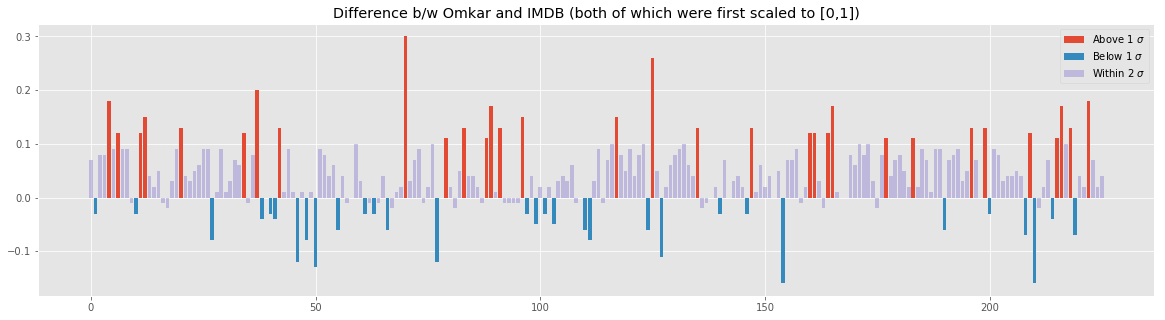

In [27]:
analyze_diff(omkar_ratings - imdb_ratings, 'Difference b/w Omkar and IMDB (both of which were first scaled to [0,1])')

This is interesting: on average, it looks like Omkar rates movies ~4% higher than IMDB. With a standard deviation of ~6%, we see that Omkar tends to genrally be more generous with his ratings.

Additionally, we can also look at the **absolute** difference b/w Omkar and IMDB in order to see which movies have very strong agreement b/w both datasets:

Max difference:  0.30000000000000004
Min difference:  0.0
Mean:  0.061637168141592924
Std dev:  0.048549502507754805
Movies that are above 1 sigma from the mean difference b/w Omkar and IMDB: (total: 32)
	Movie: 5) Seven Psycopaths (2012), diff: 0.18
	Movie: 7) Con Air (1997), diff: 0.12
	Movie: 12) Silver Linings Playbook (2012), diff: 0.12
	Movie: 13) Mere Dad Ki Maruti (2013), diff: 0.15
	Movie: 21) Killer Joe (2011), diff: 0.13
	Movie: 35) Stoker (2013), diff: 0.12
	Movie: 38) Pacific Rim (2013) , diff: 0.2
	Movie: 43) Only God Forgives (2013) , diff: 0.13
	Movie: 47) Udaan (2010) , diff: 0.12
	Movie: 51) Videodrome (1983), diff: 0.13
	Movie: 71) Speed Racer (2008) , diff: 0.3
	Movie: 78) Blade Runner (1982), diff: 0.12
	Movie: 84) The Guest (2014), diff: 0.13
	Movie: 90) John Wick (2014), diff: 0.17
	Movie: 92) Birdman (2014), diff: 0.13
	Movie: 97) You're Next (2011), diff: 0.15
	Movie: 118) The DUFF (2015), diff: 0.15
	Movie: 126) Soul Plane (2004), diff: 0.26
	Movie: 136) Wet H

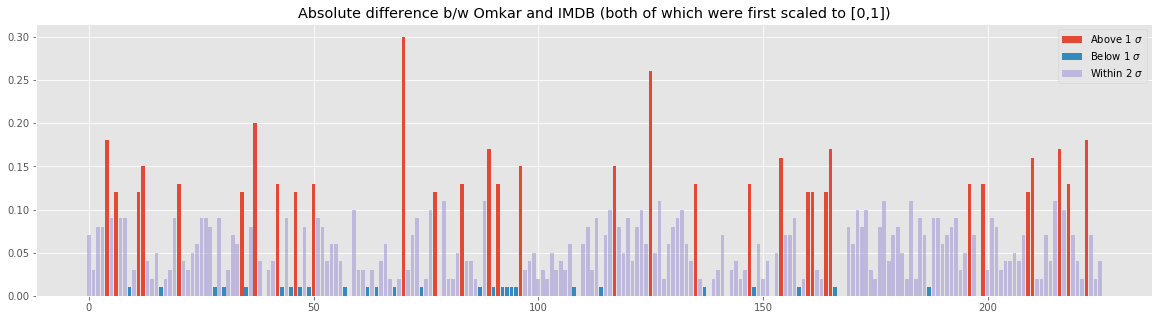

In [28]:
analyze_diff(np.abs(omkar_ratings - imdb_ratings), 'Absolute difference b/w Omkar and IMDB (both of which were first scaled to [0,1])')

### Genre-based analysis

In [24]:
# Num unique genres
all_genres = []
for raw_genres in raw_movie_genres:
    genres = raw_genres.split('/')
    for genre in genres:
        word = genre.lower().strip()
        # spelling mistakes
        if word == 'crme':
            word = 'crime'
        elif word == 'myster':
            word = 'mystery'
        all_genres.append(word)

unique_genres = sorted(set(all_genres))
counts = Counter(all_genres)
print unique_genres
print counts

['action', 'adventure', 'animation', 'biography', 'biopic', 'blaxploitation', 'body horror', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'heist', 'horror', 'music', 'mystery', 'rom-com', 'romance', 'sci-fi', 'sport', 'thriller']
Counter({'action': 82, 'comedy': 76, 'drama': 74, 'adventure': 43, 'thriller': 34, 'sci-fi': 28, 'crime': 27, 'mystery': 19, 'horror': 15, 'rom-com': 12, 'fantasy': 9, 'animation': 5, 'sport': 4, 'heist': 4, 'biography': 3, 'romance': 3, 'music': 3, 'documentary': 3, 'biopic': 2, 'blaxploitation': 1, 'body horror': 1, 'film-noir': 1})


In [25]:
max_correlation = 0
max_corr_genre = 'N/A'

for genre in unique_genres:
    use = []
    for raw_genres in raw_movie_genres:
        use.append(genre in raw_genres.lower())
    if sum(use) < 3:
        print '> Genre "{}" has too few examples ({})'.format(genre, counts[genre])
        continue
    correlation = np.corrcoef(omkar_ratings[use], imdb_ratings[use])[0, 1]
    print 'Genre: {}, Num. data pts: {}, Correlation: {}'.format(genre, counts[genre], correlation)
    
    if correlation > max_correlation:
        max_correlation = correlation
        max_corr_genre = genre



Genre: action, Num. data pts: 82, Correlation: 0.607767210592
Genre: adventure, Num. data pts: 43, Correlation: 0.787136204089
Genre: animation, Num. data pts: 5, Correlation: 0.727451044419
Genre: biography, Num. data pts: 3, Correlation: 0.998221166691
> Genre "biopic" has too few examples (2)
> Genre "blaxploitation" has too few examples (1)
> Genre "body horror" has too few examples (1)
Genre: comedy, Num. data pts: 76, Correlation: 0.699150172174
Genre: crime, Num. data pts: 27, Correlation: 0.668399201081
Genre: documentary, Num. data pts: 3, Correlation: 1.40998465126e-15
Genre: drama, Num. data pts: 74, Correlation: 0.651078456144
Genre: fantasy, Num. data pts: 9, Correlation: 0.68665053402
> Genre "film-noir" has too few examples (1)
Genre: heist, Num. data pts: 4, Correlation: 0.971665620578
Genre: horror, Num. data pts: 15, Correlation: 0.716856681088
Genre: music, Num. data pts: 3, Correlation: 0.789865330519
Genre: mystery, Num. data pts: 19, Correlation: 0.580189889402
Ge

In [ ]:
print "Max. correlated genre: {}, ({})".format(max_corr_genre, max_correlation)